# `StableSpectralElements.jl` - 3D linear advection example

First, let's load the required packages.

In [288]:
using StableSpectralElements, OrdinaryDiffEq, LinearAlgebra, StartUpDG
using Plots, Plots.PlotMeasures, Printf, TimerOutputs, BenchmarkTools, PrettyTables

We will solve the three-dimensional linear advection equation
$$
\partial_t U(\boldsymbol{x},t) + \nabla_{\boldsymbol{x}} \cdot (\boldsymbol{a} U(\boldsymbol{x},t)) = 0,  \quad \forall\, (\boldsymbol{x}, t) \in \Omega \times (0,T),
$$
with $a = [1,1,1]^{\mathrm{T}}$ and $\Omega = (0,L)^3$, where we take $L = 1$, and $T = 1$, and impose periodic boundary conditions as well as the initial condition
$$
U(\boldsymbol{x},0) = \cos(2\pi x_1 / L)\cos(2\pi x_2 / L)\cos(2\pi x_3 / L), \quad \forall \, \boldsymbol{x} \in \Omega.
$$

In [289]:
a = (1.0,1.0,1.0)  # advection velocity
L = 1.0  # domain length
T = 1.0  # end time

conservation_law = LinearAdvectionEquation(a)
exact_solution = InitialDataSine(1.0,(2π/L, 2π/L, 2π/L));

We'll discretize the above problem using a `ModalTensor` discretization of degree $p = 7$, on a curved (i.e. using a mapping of degree $p_{\mathrm{map}} = 3$) tetrahedral mesh with $M = 2$ edges in each direction. A skew-symmetric split form will be used to treat the curvilinear coordinate transformation in a provably stable manner, and we will use an upwind (i.e. Lax-Friedrichs) numerical flux.

In [290]:
M = 2
p = 1

reference_approximation = ReferenceApproximation(
    ModalMulti(p), Tet(), mapping_degree=1)

form = StandardForm(mapping_form=StandardMapping(), 
    inviscid_numerical_flux=LaxFriedrichsNumericalFlux())

uniform_mesh = uniform_periodic_mesh(
            reference_approximation.reference_element, 
            Tuple((0.0,L) for m in 1:3), Tuple(M for m in 1:3),
            collapsed_orientation=false, tol=1.0e-10)

mesh = warp_mesh(uniform_mesh, reference_approximation, 
    ChanWarping(1.0/16.0,Tuple(L for m in 1:3)))

spatial_discretization = SpatialDiscretization(mesh, 
    reference_approximation, ExactMetrics())

results_path = save_project(conservation_law,
     spatial_discretization, exact_solution, form, (0.0, T),
     "results/advection_3d/", overwrite=true, clear=true);

We will now plot the reference element, with the volume quadrature nodes shown on the left and the facet quadrature nodes shown on the right.

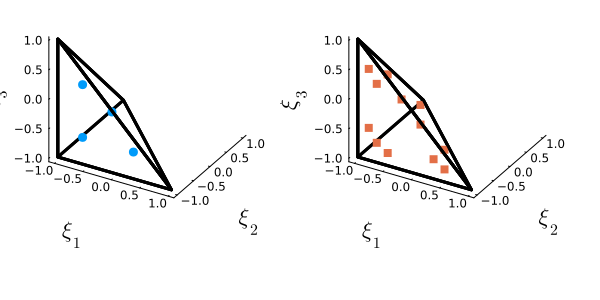

In [291]:
vol_quad_plot = plot(reference_approximation, volume_connect=false, 
    facet_quadrature=false, fmt=:png, size=(300,300))
fac_quad_plot = plot(reference_approximation, facet_connect=false, 
    volume_quadrature=false, fmt=:png, size=(300,300), facet_inds=[3,4,1,2])
plot(vol_quad_plot,fac_quad_plot,size=(600,300),margin=5mm, fmt=:png)

The mesh is shown below.

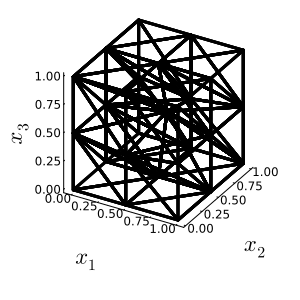

In [292]:
plot(spatial_discretization, volume_quadrature=false, facet_quadrature=false, fmt=:png, size=(300,300))

Using the `semidiscretize` function, we can create an `ODEProblem` object for use with OrdinaryDiffEq.jl's `solve` function. Here we've chosen the option for a weight-adjusted approximation of the mass matrix inverse from [Chan et al. (SISC 2017)](https://arxiv.org/abs/1608.03836), which allows for modal schemes to be applied efficiently at high order with explicit time-marching methods.

In [293]:
C_t = 0.05
h = L/M
dt = C_t*h/(norm(a)*p^2)

ode_problem = semidiscretize(conservation_law, spatial_discretization,
    exact_solution, form, (0.0, T), PhysicalOperator());

In [294]:
reset_timer!()
sol = solve(ode_problem, CarpenterKennedy2N54(), adaptive=false, dt=dt,
    save_everystep=false, 
    callback=save_callback(results_path, (0.0,T), floor(Int, T/(dt*50))))
print_timer()

 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:           69.2ms /  40.8%           19.2MiB /  85.4%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 semi-disc. residual      422   28.2ms  100.0%  66.9μs   16.4MiB  100.0%  39.9KiB
 ────────────────────────────────────────────────────────────────────────────────


We can then compute the $L^2$ norm of the solution error using the scheme's volume quadrature rule.

In [295]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
println("L2 error:")
println(analyze(error_analysis, last(sol.u), exact_solution, T)...)
#0.36089085843063934
#0.36057929475673706
#0.1579510313919966

L2 error:
0.2321922429953545


The conservation and energy dissipation properties of the scheme are verified as follows.

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194


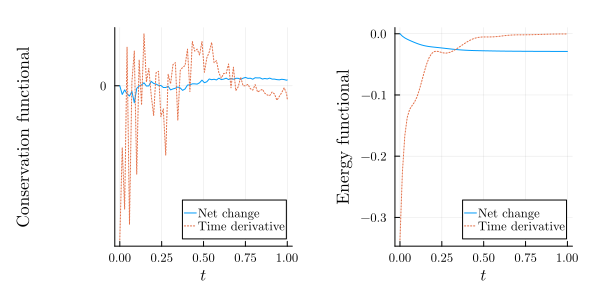

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194


In [296]:
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
p1 = plot(analyze(conservation_analysis, load_time_steps(results_path)), 
    ylabel="Conservation functional",)
p2 = plot(analyze(energy_analysis, load_time_steps(results_path)), 
    ylabel="Energy functional")
plot(p1,p2, size=(600,300),margin=5mm, fmt=:png)

We can now postprocess the solution for visualization, producing a `.vtu` file.

In [297]:
postprocess_vtk(spatial_discretization,
    string(results_path,"solution.vtu"), last(sol.u));

In [298]:
check_sbp_property(spatial_discretization)

(4.092863201132778e-18, 3.469446951953614e-18, 4.235133150553689e-18)

In [299]:
V_rst = grad_vandermonde(Tet(), p, reference_approximation.reference_element.rstq...)
Vf = vandermonde(Tet(), p, reference_approximation.reference_element.rstf...)

12×4 Matrix{Float64}:
 0.866025  -0.372678  -1.31762   -1.36931
 0.866025  -0.372678  -1.31762    1.36931
 0.866025   1.86339   -0.527046  -1.21619e-15
 0.866025   1.86339    0.263523   0.456435
 0.866025  -0.372678  -0.527046   1.82574
 0.866025  -0.372678   1.84466    0.456435
 0.866025  -0.372678  -0.527046  -1.82574
 0.866025  -0.372678   1.84466   -0.456435
 0.866025   1.86339    0.263523  -0.456435
 0.866025  -1.11803   -0.790569  -1.36931
 0.866025  -1.11803   -0.790569   1.36931
 0.866025  -1.11803    1.58114   -1.21619e-15

In [300]:
V_rst = reference_approximation.D[1] * reference_approximation.V

4×4 LinearMaps.CompositeMap{Float64} with 2 maps:
  4×4 OctavianMap{Float64}
  4×4 OctavianMap{Float64}

In [301]:
println(round.(Matrix(ode_problem.p.operators.VOL[1][1])[3,:]; digits=3))

[0.0, 0.0, 0.0, 0.0]


In [302]:
println(round.(Matrix(ode_problem.p.operators.FAC[1])[3,:]; digits=3))

[3.514, 3.514, 1.405, -0.994, 1.988, -6.957, 1.988, -6.957, -0.994, 2.108, 2.108, -4.216]
